In [31]:
if (!require("data.table")) install.packages("data.table")
library ("data.table")

if (!require("TSA")) install.packages("TSA")
library ("TSA")

if (!require("quantmod")) install.packages("quantmod")
library ("quantmod")

if (!require("tseries")) install.packages("tseries")
library ("tseries")

if (!require("fGarch")) install.packages("fGarch")
library ("fGarch")

if (!require("mgcv")) install.packages("mgcv")
library ("mgcv")

if (!require("rugarch")) install.packages("rugarch")
library ("rugarch")


# Load Data

ï..observation_date,GNP
1947-01-01,244.058
1947-04-01,247.362
1947-07-01,251.246
1947-10-01,261.545
1948-01-01,267.564
1948-04-01,274.376


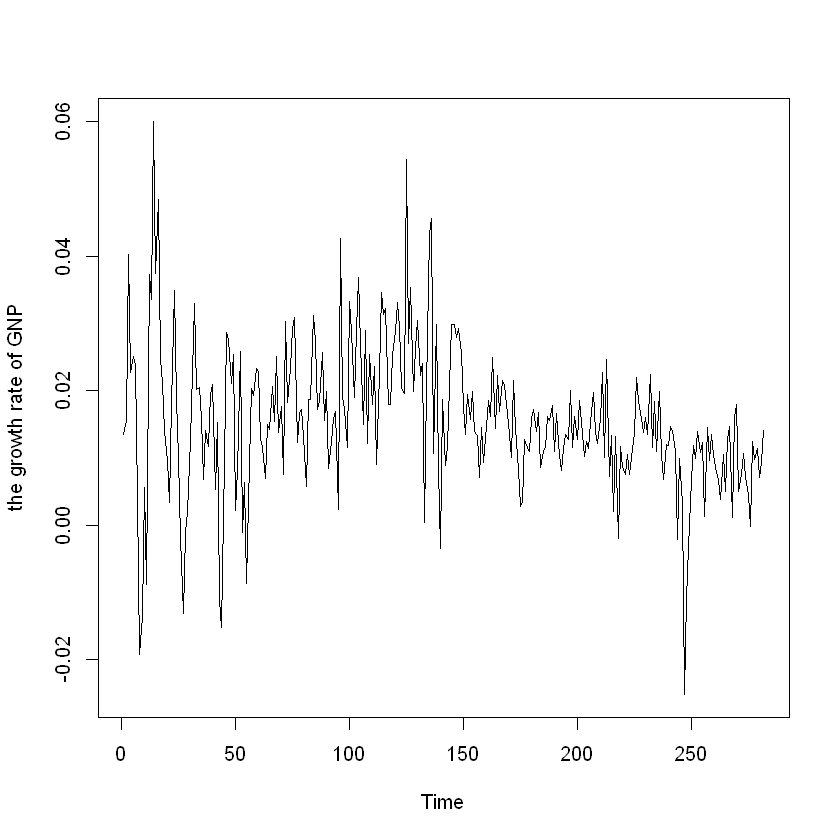

In [2]:
gnp = read.csv("GNP.csv",header=T)
head(gnp)
gnp=gnp[,2]
gnpgr=diff(log(gnp))
ts.plot(gnpgr,ylab="the growth rate of GNP")

n=length(gnpgr)
gnpgr.test = gnpgr[200:n]
gnpgr.train =  gnpgr[-c(200:n)]


# Question 1: ARIMA(p,d,q) Model
For the gnpgr.train data, find the best ARIMA (p,d,q) model where  4>p , 2>d and 4>q  based on AIC.  

What are the estimated parameters of the selected model?Draw the ACF of the residuals and squared residuals 
and check if there is a heterscedasticity effect by using an appropriate test method you learned in the course.


Define a function to fit ARIMA

In [3]:
fit_arima = function(ts_data,max_p = 7,max_d = 1,max_q = 7){
  
  final.aic = Inf
  final.order = c(0,0,0)
  for (p in 0:max_p) for (d in 0:max_d) for (q in 0:max_q) {
    current.aic = AIC(arima(ts_data, order=c(p, d, q)))
    if (current.aic < final.aic) {
      final.aic = current.aic
      final.order = c(p, d, q)
      final.arima = arima(ts_data, order=final.order)
    }
  }
    
    results = list()
    results$porder = final.order[1]
    results$dorder = final.order[2]
    results$qorder = final.order[3]
    
    results$final_order = final.order
    results$final_model= final.arima
    results$final_model_residual = resid(final.arima)
    
    return (results) 
  }

In [4]:
ARIMA_model = fit_arima(ts_data = gnpgr.train,max_p = 3,max_d = 1,max_q = 3)

message("The p order is ", ARIMA_model$porder,"\n")
message("The d order is ", ARIMA_model$dorder,"\n")
message("The q order is ", ARIMA_model$qorder,"\n")

The p order is 3

The d order is 0

The q order is 2



In [5]:
message("The ARIMA model parameter is the following: \n")
ARIMA_model$final_model

The ARIMA model parameter is the following: 




Call:
arima(x = ts_data, order = final.order)

Coefficients:
         ar1      ar2     ar3      ma1     ma2  intercept
      1.7738  -1.4121  0.2980  -1.3769  0.9315     0.0177
s.e.  0.0830   0.1331  0.0828   0.0447  0.0631     0.0011

sigma^2 estimated as 9.761e-05:  log likelihood = 635.76,  aic = -1259.52

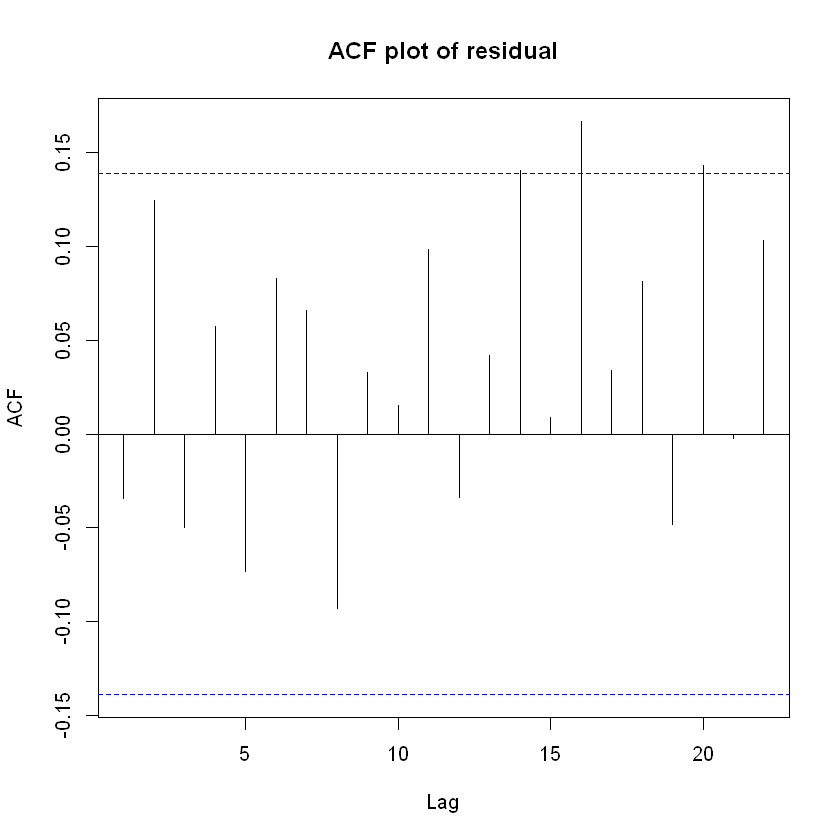

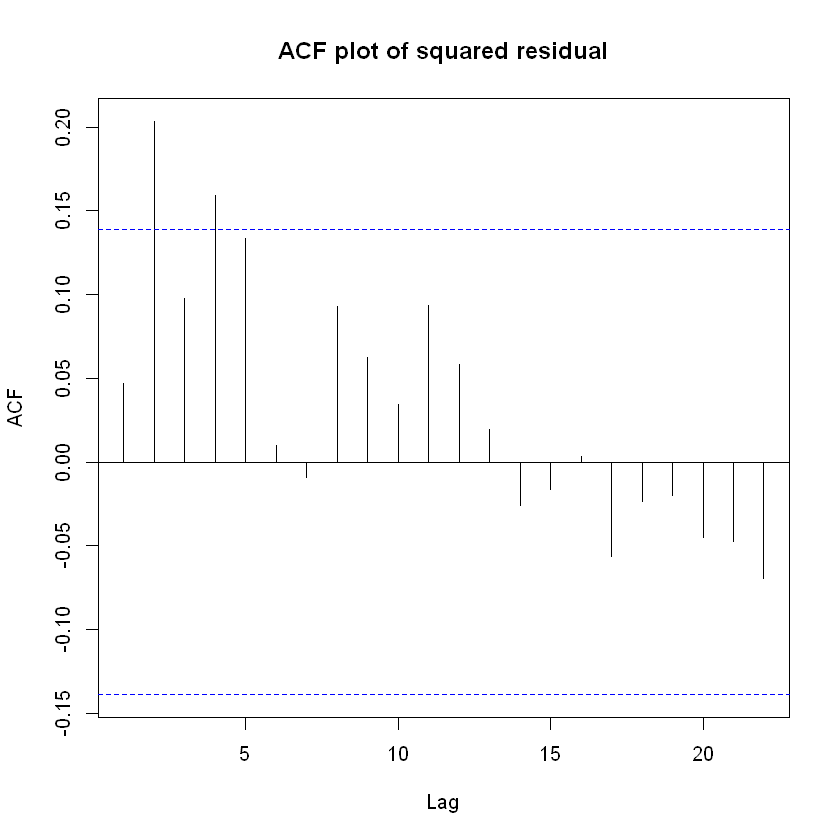

In [6]:
# Draw ACF of the residual and square residuals
acf(as.numeric(ARIMA_model$final_model_residual), main = "ACF plot of residual")
acf(as.numeric(ARIMA_model$final_model_residual^2), main = "ACF plot of squared residual")

In [7]:
correlation_box_test <- function(ts_residual,porder,dorder,qorder){
  #A = Box.test(ts_residual, lag = (porder+qorder+1), type = "Box-Pierce", fitdf = (porder+qorder))
  B = Box.test(ts_residual, lag = (porder+qorder+1), type = "Ljung-Box", fitdf = (porder+qorder))
  
  #print (A)
  print (B)
}

message ("The result of Ljung-Box test for residual is the following: \n")
correlation_box_test(ARIMA_model$final_model_residual,porder = ARIMA_model$porder,
                     dorder = ARIMA_model$dorder, qorder = ARIMA_model$qorder)

message ("The result of Ljung-Box test for squared residual is the following: \n")
correlation_box_test(ARIMA_model$final_model_residual^2,porder = ARIMA_model$porder,
                     dorder = ARIMA_model$dorder, qorder = ARIMA_model$qorder)

The result of Ljung-Box test for residual is the following: 




	Box-Ljung test

data:  ts_residual
X-squared = 7.1173, df = 1, p-value = 0.007634



The result of Ljung-Box test for squared residual is the following: 




	Box-Ljung test

data:  ts_residual
X-squared = 19.688, df = 1, p-value = 9.117e-06



In [8]:
message ("p value is for both the residual and squared residuals are smaller than 0.05, reject the null hypothesis that the residuals or squared residual are uncorrelated. This suggest that this ARIMA model does not lead to uncorrelated residuals or squared residuals. Since the squared residuals shows significant value at some lag, it indicates that heteroscedasticity is in effect.")

p value is for both the residual and squared residuals are smaller than 0.05, reject the null hypothesis that the residuals or squared residual are uncorrelated. This suggest that this ARIMA model does not lead to uncorrelated residuals or squared residuals. Since the squared residuals shows significant value at some lag, it indicates that heteroscedasticity is in effect.


# Quesiton 2: ARIMA(p,d,q)-GARCH(m,n) Model
For the gnpgr.train data, based on BIC and using a refinement strategy, find the best LaTeX: ARIMA (p,d,q ) − G A R C H ( m , n ) with ( p , d , q )  you selected in Question 1.  Explain why you chose this model.

Write the full mathematical representation of the best model with the estimated values.

Define a function to fit GARCH order given Arima Model

In [9]:
fit_GARCH_given_ARIMA = function(ts_data,ARIMA_p = 1, ARIMA_q = 1, max_m = 3, max_n = 3){
  start_time = Sys.time()
  # a function for fitting ARIMA (p,q,d) - GARCH (m,n) model 
  #given that the order of ARIMA model is provided
  
  final.bic = Inf
  final.order.garch = c(0,0)
  for (m in 0:max_m) for (n in 0:max_n){
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                      mean.model=list(armaOrder=c(ARIMA_p, ARIMA_q), 
                                      include.mean=T), distribution.model="std")    
    fit = ugarchfit(spec, ts_data, solver = 'hybrid')
    current.bic = infocriteria(fit)[2] 
    if (current.bic < final.bic) {
      final.bic = current.bic
      final.order.garch = c(m, n)
      final.order.arima = c(ARIMA_p, ARIMA_q)
      final_model = fit
      final_spec = spec
    }
  }
  end_time = Sys.time()
  message("It took ", round(end_time-start_time,2), " seconds to fit the ARIMA GARCH model")
  
  results = list()
  results$ARIMA_porder = ARIMA_p
  results$ARIMA_qorder = ARIMA_q
  results$final_ARIMA_order = final.order.arima
  
  results$final_spec = final_spec
  results$GARCH_morder = final.order.garch[1]
  results$GARCH_norder = final.order.garch[2]
  
  results$final_GARCH_order= final.order.garch
  results$final_model =  final_model
  results$residuals = residuals(final_model)
  results$BIC = final.bic
  
  message ("The final ARIMA order is (", ARIMA_p, ",", 0, ",", ARIMA_q, ")")
  message ("The final GARCH order is (", final.order.garch[1], ",", final.order.garch[2], ")")
  
  
  return (results) 
}

Define another function to fit ARIMA order given GARCH order is provided

In [10]:
fit_ARIMA_given_GARCH = function(ts_data,GARCH_m = 1, GARCH_n = 1, max_p = 3, max_q = 3){
  start_time = Sys.time()
  # a function for fitting ARIMA (p,q,d) - GARCH (m,n) model 
  #given that the order of ARIMA model is provided
  
  final.bic = Inf
  final.order.garch = c(0,0)
  
  m = GARCH_m 
  n = GARCH_n
  
  for (p in 0:max_p) for (q in 0:max_q){
    spec = ugarchspec(variance.model=list(garchOrder=c(m,n)),
                      mean.model=list(armaOrder=c(p, q), 
                                      include.mean=T), distribution.model="std")    
    fit = ugarchfit(spec, ts_data, solver = 'hybrid')
    current.bic = infocriteria(fit)[2] 
    if (current.bic < final.bic) {
      final.bic = current.bic
      final.order.garch = c(m, n)
      final.order.arima = c(p, q)
      final_model = fit
      final_spec = spec
    }
  }
  
  end_time = Sys.time()
  message("It took ", round(end_time-start_time,2), " seconds to fit the ARIMA-GARCH model")
  
  results = list()
  results$ARIMA_porder = final.order.arima[1]
  results$ARIMA_qorder = final.order.arima[2]
  results$final_ARIMA_order = final.order.arima
  
  results$GARCH_morder = m
  results$GARCH_norder = n
  results$final_GARCH_order= final.order.garch
  
  results$final_spec = final_spec
  results$final_model =  final_model
  results$residuals = residuals(final_model)
  results$BIC = final.bic
  
  message ("The final ARIMA order is (", final.order.arima[1], ",", 0, ",", final.order.arima[2], ")")
  message ("The final GARCH order is (", final.order.garch[1], ",", final.order.garch[2], ")")
  
  return (results) 
}

1. Find Garch order given the ARIMA order from Question 1

In [11]:
ARIMA_GARCH_model_1 = fit_GARCH_given_ARIMA(ts_data = gnpgr.train, ARIMA_p = ARIMA_model$porder,
                              ARIMA_q = ARIMA_model$qorder, max_m = 6, max_n = 6)

It took 37.58 seconds to fit the ARIMA GARCH model
The final ARIMA order is (3,0,2)
The final GARCH order is (1,1)


2. Refine ARIMA order based on the GARCH order

In [12]:
ARIMA_GARCH_model_2 = fit_ARIMA_given_GARCH(ts_data = gnpgr.train, GARCH_m = ARIMA_GARCH_model_1$GARCH_morder,
                                            GARCH_n = ARIMA_GARCH_model_1$GARCH_norder,
                                            max_p = 3,max_q = 3)

It took 4.44 seconds to fit the ARIMA-GARCH model
The final ARIMA order is (3,0,0)
The final GARCH order is (1,1)


3. Further refine the GARCH order based on the ARIMA order found in step 2

In [13]:
ARIMA_GARCH_model_3 = fit_GARCH_given_ARIMA(ts_data = gnpgr.train, ARIMA_p = ARIMA_GARCH_model_2$ARIMA_porder,
                                            ARIMA_q = ARIMA_GARCH_model_2$ARIMA_qorder, max_m = 6, max_n = 6)

It took 29.47 seconds to fit the ARIMA GARCH model
The final ARIMA order is (3,0,0)
The final GARCH order is (1,1)


In [14]:
message ("model 2 and model 3 are the same")

model 2 and model 3 are the same


To select the order, compare the information criteriation

In [15]:
infocriteria(ARIMA_GARCH_model_1$final_model)
infocriteria(ARIMA_GARCH_model_2$final_model)

,
Akaike,-6.472623
Bayes,-6.307130
Shibata,-6.477359
Hannan-Quinn,-6.405644


,
Akaike,-6.486115
Bayes,-6.353721
Shibata,-6.489184
Hannan-Quinn,-6.432532


In [16]:
message ("All information criteria indicate that model 1 is smaller, so model 1 will be the best model 
ARIMA order is (3,0,2)
GARCH order is (1,1)")

All information criteria indicate that model 1 is smaller, so model 1 will be the best model 
ARIMA order is (3,0,2)
GARCH order is (1,1)


Perform Residual test

In [17]:
ARIMA_GARCH_residual_test = function(rugarch_model){
  
    resids.final.model = residuals(rugarch_model$final_model)

    fitdf = sum(rugarch_model$final_ARIMA_order, rugarch_model$final_GARCH_order)
    
    message ("Ljung-box test for residual")
    print (Box.test(resids.final.model,lag=fitdf+1,type='Ljung',fitdf=fitdf))
    message ("Ljung-box test for residual squared")
    print (Box.test(resids.final.model^2,lag=fitdf+1,type='Ljung',fitdf=fitdf))
    
    acf(resids.final.model,main="ACF of ARCH Residuals")
    acf(resids.final.model^2,main="ACF of Squared ARCH Residuals")
    
    qqnorm(resids.final.model)
    qqline(resids.final.model)
}

Ljung-box test for residual



	Box-Ljung test

data:  resids.final.model
X-squared = 5.4567, df = 1, p-value = 0.01949



Ljung-box test for residual squared



	Box-Ljung test

data:  resids.final.model^2
X-squared = 14.812, df = 1, p-value = 0.0001188



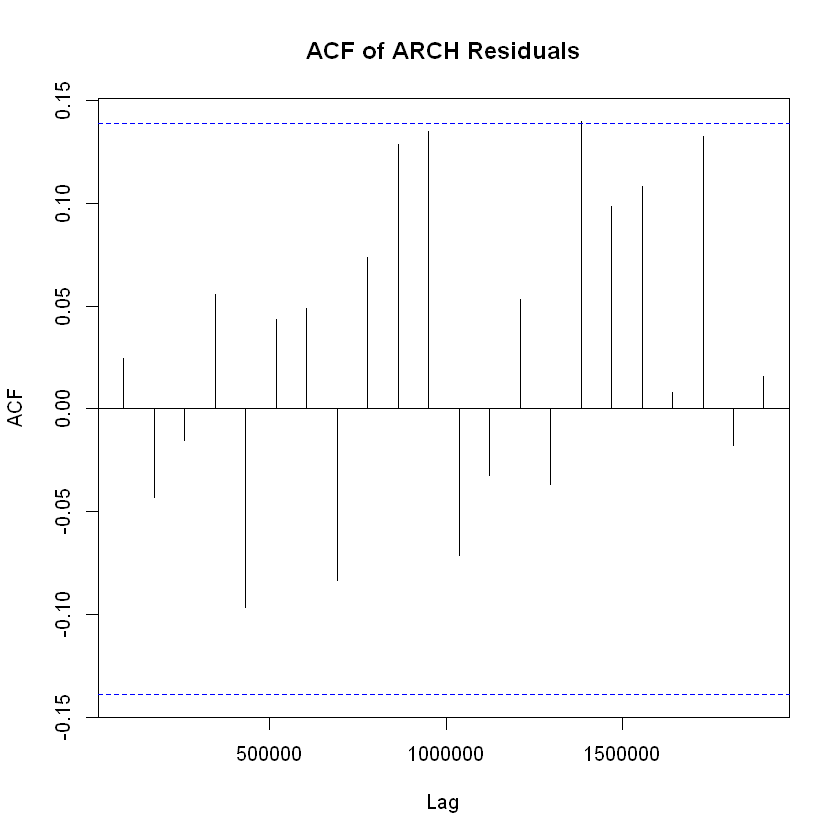

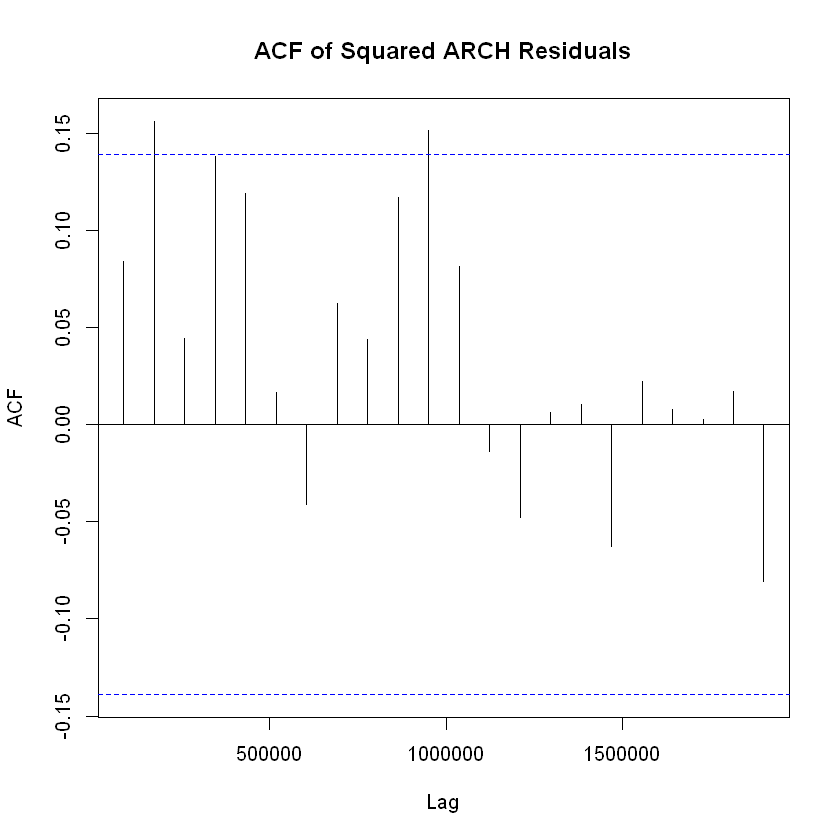

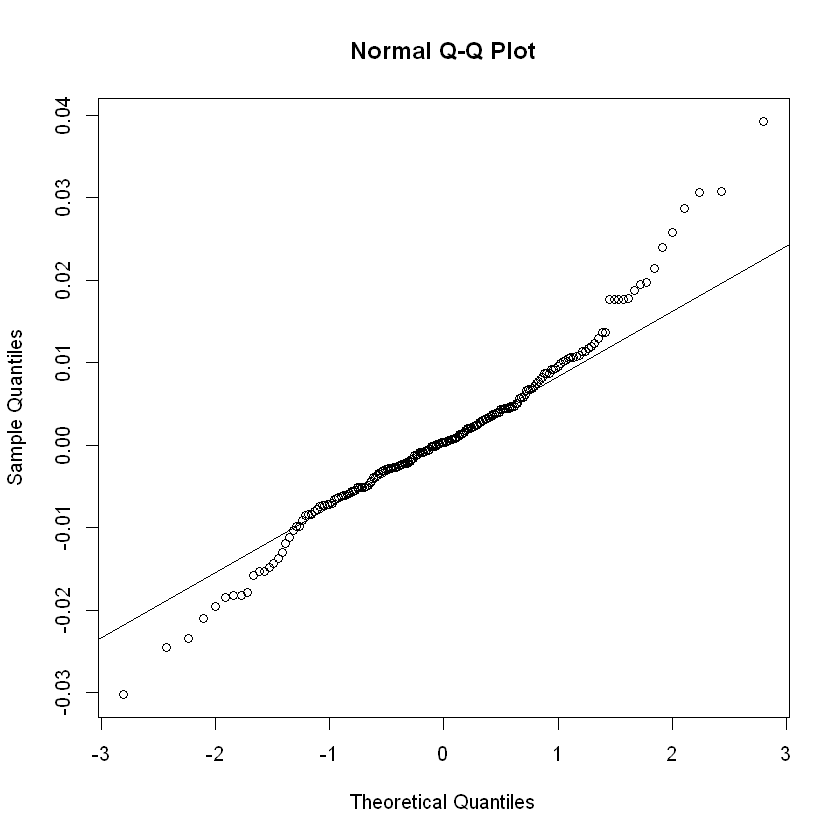

In [24]:
ARIMA_GARCH_residual_test (ARIMA_GARCH_model_1)

Ljung-box test for residual



	Box-Ljung test

data:  resids.final.model
X-squared = 7.3564, df = 1, p-value = 0.006683



Ljung-box test for residual squared



	Box-Ljung test

data:  resids.final.model^2
X-squared = 16.272, df = 1, p-value = 5.488e-05



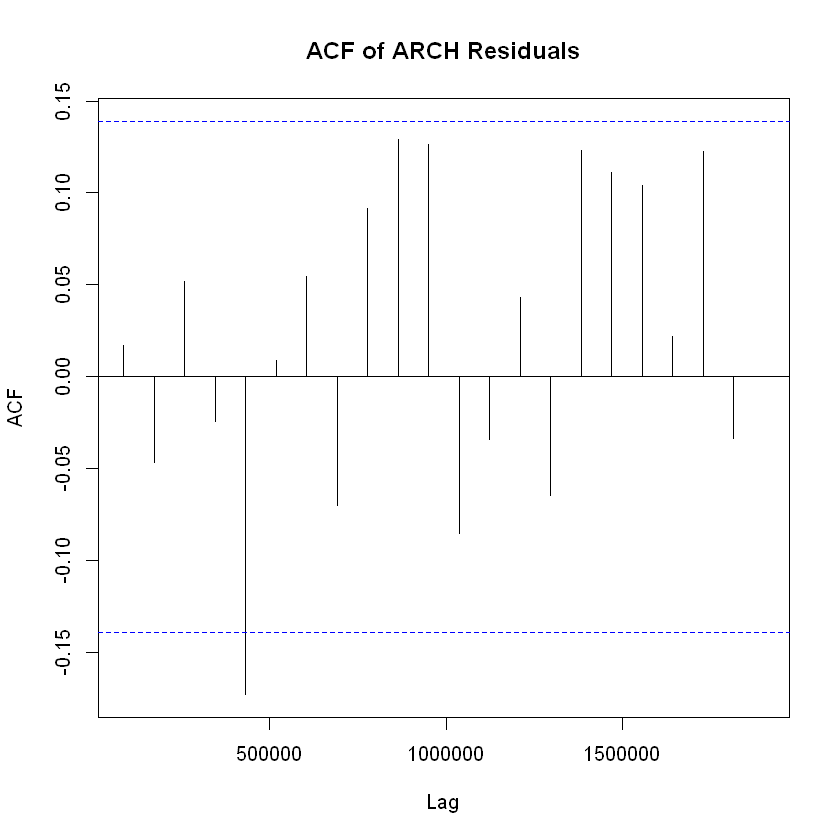

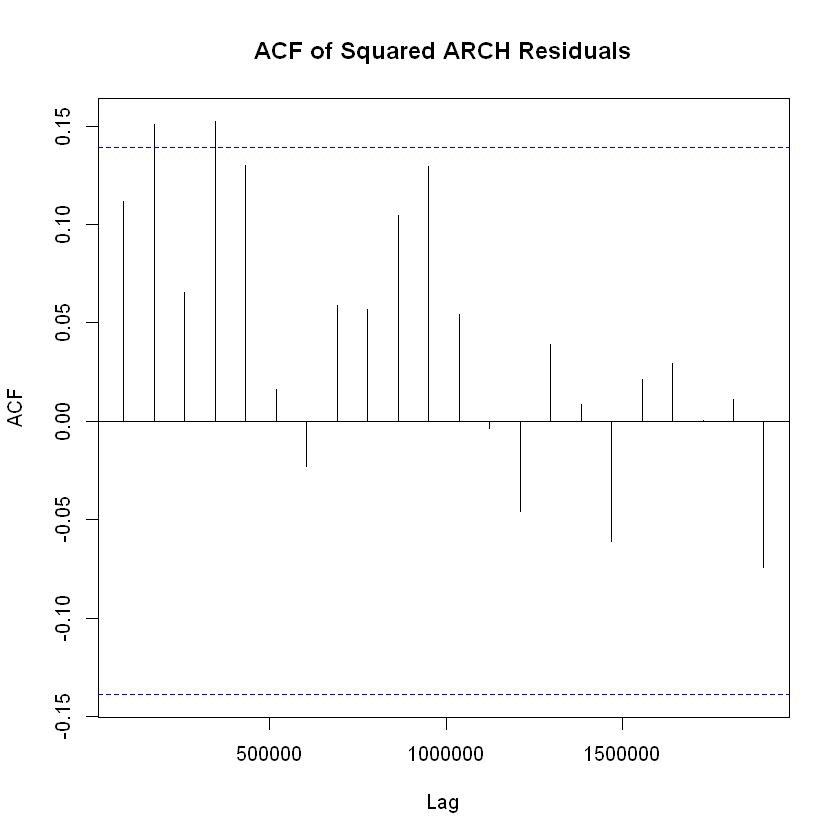

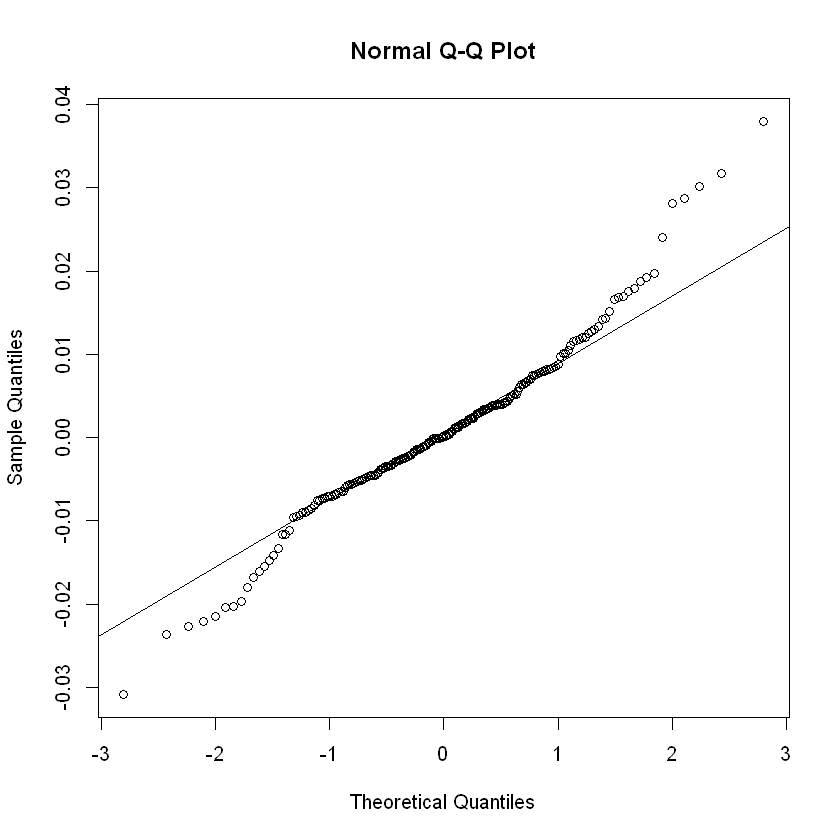

In [25]:
ARIMA_GARCH_residual_test (ARIMA_GARCH_model_2)

In [20]:
message ("Residual analysis shows that both model shows signs of correlated residual, and the QQ plot also indicate that the residuals are not normally distributed for these two models. 
Thus based on the information criterion and residual analysis, model 1 will be the best")

Residual analysis shows that both model shows signs of correlated residual, and the QQ plot also indicate that the residuals are not normally distributed for these two models. 
Thus based on the information criterion and residual analysis, model 1 will be the best


In [26]:
ARIMA_GARCH_model_1$final_model


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(3,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.016153    0.000905 17.84154 0.000000
ar1     0.892013    0.373492  2.38831 0.016926
ar2    -0.245407    0.423844 -0.57900 0.562588
ar3    -0.100885    0.139741 -0.72194 0.470332
ma1    -0.513346    0.375887 -1.36569 0.172035
ma2     0.290311    0.268798  1.08003 0.280128
omega   0.000004    0.000007  0.56289 0.573507
alpha1  0.197855    0.091968  2.15134 0.031449
beta1   0.784711    0.089463  8.77135 0.000000
shape   4.905433    1.711750  2.86574 0.004160

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.016153    0.001170 13.80075 0.000000
ar1     0.892013    0.579754  1.53861 0.123900
ar2    -0

In [27]:
#Optimal Parameters
#------------------------------------
#        Estimate  Std. Error  t value Pr(>|t|)
#mu      0.016153    0.000905 17.84154 0.000000
#ar1     0.892013    0.373492  2.38831 0.016926
#ar2    -0.245407    0.423844 -0.57900 0.562588
#ar3    -0.100885    0.139741 -0.72194 0.470332
#ma1    -0.513346    0.375887 -1.36569 0.172035
#ma2     0.290311    0.268798  1.08003 0.280128
#omega   0.000004    0.000007  0.56289 0.573507
#alpha1  0.197855    0.091968  2.15134 0.031449
#beta1   0.784711    0.089463  8.77135 0.000000
#shape   4.905433    1.711750  2.86574 0.004160

In [28]:
message ("The formula for the ARIMA (3,0,2) - GARCH (1,1) is shown below:")

The formula for the ARIMA (3,0,2) - GARCH (1,1) is shown below:


![alt text](formula.png "Title")

# Question 3: Forecasting
Keep the gnpgr.test data points for testing.  Generate forecasts of those 83 test data and compare predictions to the actual values.  
Provide accuracy measure and a  plot consisting of both predicted and actual values.

Wrapping prediction, plotting, calculating accuracy measure in a function

In [29]:
generate_GARCH_forecast = function(data.train, data.test, ugarch_spec){
  nfore = length(data.test)
  fore.series = NULL
  fore.sigma = NULL
  
  for(f in 1: nfore)
  {
    #Fit models
    data = data.train
    if(f>2)
      data = c(data.train,data.test[1:(f-1)])  
      model = ugarchfit(ugarch_spec, data, solver = 'hybrid')  
    #Forecast
      fore = ugarchforecast(model, n.ahead=1)
      fore.series = c(fore.series, fore@forecast$seriesFor)
      fore.sigma = c(fore.sigma, fore@forecast$sigmaFor)
  }
  
   #Mean Prediction Comparison Plot
   n=length(data.train)+length(data.test)
   ymin = min(na.omit(c(as.vector(data.test),fore.series)))
   ymax = max(na.omit(c(as.vector(data.test),fore.series)))
   
   data.plot = data.test
   names(data.plot)="Fore"
   
   plot(data.test,type="l", ylim=c(ymin,ymax), xlab="Time", 
        ylab="GNPGR",main="Mean Prediction Comparison",lwd = 2, col = "black")
   lines(fore.series,lwd= 2, col="blue")
   
   legend(x = "bottomleft",legend=c("Actual","Predicted"),col=c("black","blue"),lty=1,lwd=2) # Add Legend
   
   
   
   # calculate print accuracy measure
   #Mean Squared Prediction Error (MSPE)
   MSPE = mean(na.omit((fore.series - data.test)^2))
   #Mean Absolute Prediction Error (MAE)
   MAE = mean(na.omit(abs(fore.series - data.test)))
   #Mean Absolute Percentage Error (MAPE)
   MAPE = mean(na.omit(abs(fore.series - data.test)/(data.test+0.000001)))
   #Precision Measure (PM)
   PM = sum(na.omit((fore.series - data.test)^2)/sum((data.test-mean(data.test))^2))
   
   message ("The MSPE is ", round(MSPE,4),"\n")
   message ("The MAE is ", round(MAE,4),"\n")
   message ("The MAPE is ", round(MAPE,4),"\n")
   message ("The PM is ", round(PM,4),"\n")
   # return results
   
   results = list()
   results$forecast = fore.series
   results$MSPE = MSPE
   results$MAE = MAE
   results$MAPE = MAPE
   results$PM = PM
   return (results)
}

The MSPE is 0

The MAE is 0.0048

The MAPE is -0.1887

The PM is 0.9463



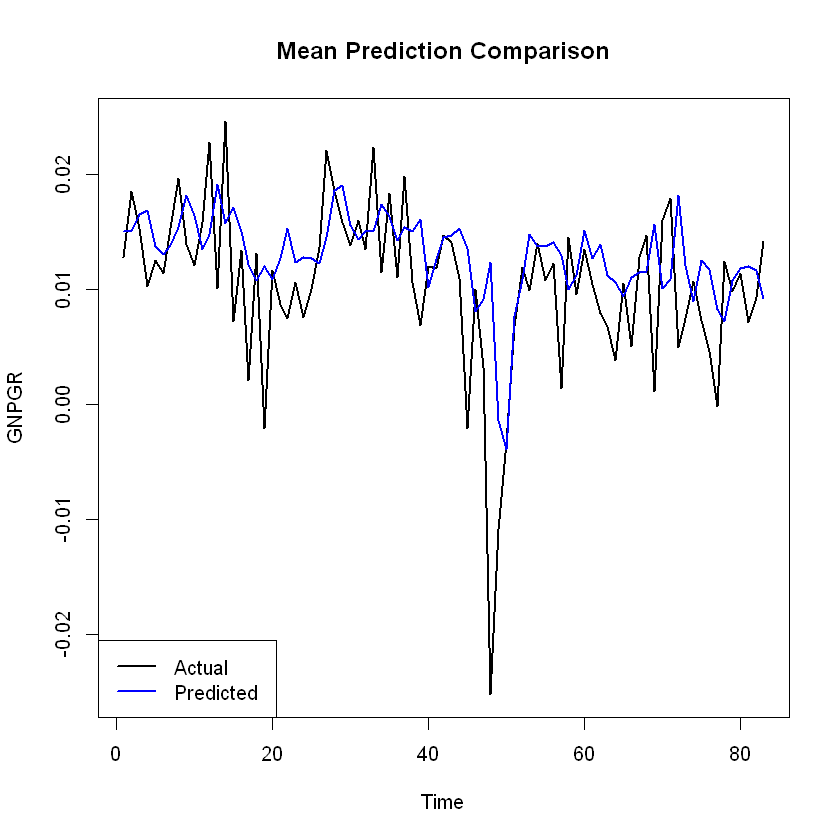

In [30]:
forecast = generate_GARCH_forecast(data.train = gnpgr.train,data.test = gnpgr.test,
                            ugarch_spec = ARIMA_GARCH_model_1$final_spec)